In [ ]:
#default_exp 1d_waveform

# Training Overview

The goal here is to learn a low-dimensional function which encodes the waveform (amplitude) of the surf.

We have the following to work with:
1. A normalized greyscale video tensor of shape (y,x,t)
1. An incomplete supervisory signal tensor which correlates to high-amplitude (the foam wavefronts of broken waves) of shape (y,x,t)

The eventual goal here is to learn a mapping from `greyscale_video_tensor` to a function `amplitude(x,y,t)` which respects various known physical constraints on the waveform. Learning this waveform will give us the ability to train better wave detection models and infer more information about the surfbreak such as bathometry (shape of the ocean floor).

## Verifying the Setup
Initially, we want to verify the basic assumptions and get this working in 1 spatial dimension (a vertical slice in the calibrated video) and 1 time dimension. 

In this simplified setting, the amplitude function would look like $amplitude = f(x, t)$

We may want to start by parameterizing f(x,t) using an set of fourier kernels as used in this paper:
https://github.com/tancik/fourier-feature-networks

From that paper, the input encoder for a 1-dimensional fit is: 
```
input_encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x[...,None]) * b), 
                                                a * np.cos((2.*np.pi*x[...,None]) * b)], axis=-1) / np.linalg.norm(a)
```

The general steps to follow (using only a vertical slice of the input video) are:
1. Test the concept initially by directly regressing f(x,t) on the encoded supervisory signal. 
1. Apply some physics domain knowledge (see `01_wave_modeling.ipynb`) to regularize the regressed waveform.
1. Learn to regress from the normalized video itself, using the supervisory signal only as a piece of the loss function (instead of as input).


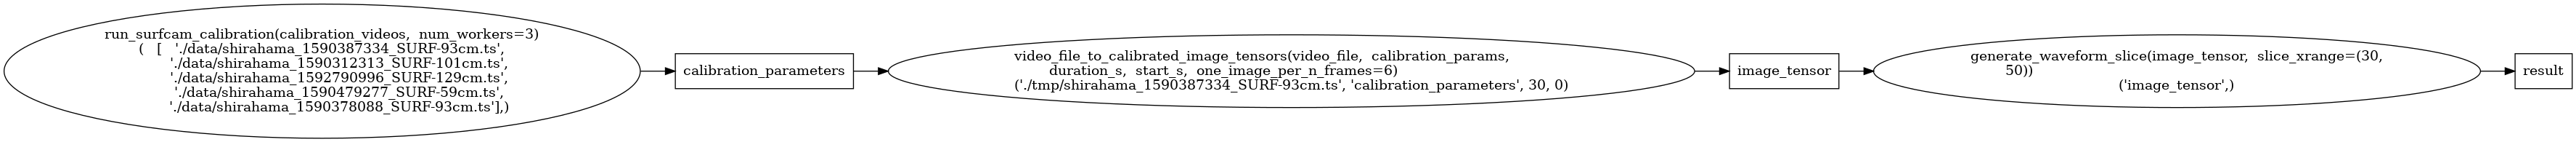

In [ ]:
%load_ext autoreload
%autoreload 2
from surfbreak import graphutils, supervision
import pipelines
import graphchain
import dask
import matplotlib.pyplot as plt

show_image = supervision.show_image

# TODO: Improve this pipeline to chunk the image_tensor (memory usage...). 

# These tensors are 10hz by default (1/6th of the frames from a of 60Hz video)
waveform_slice_graph = pipelines.video_to_waveform_slice('./tmp/shirahama_1590387334_SURF-93cm.ts',
                                                                duration_s=30, start_s=0)

graphutils.visualize(waveform_slice_graph)

### Define the inputs

In [ ]:
img_tensor = graphchain.get(waveform_slice_graph, "image_tensor")
wavefront_tensor = supervision.dilate_tensor(supervision.wavefront_diff_tensor(img_tensor))
supervision.animate_tensor(wavefront_tensor[...,::5])

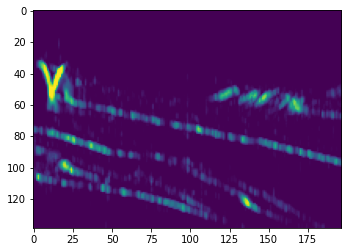

In [ ]:
waveform_slice = graphchain.get(waveform_slice_graph, "result").astype('float32')
plt.imshow(waveform_slice[...,100:400])

## Next Steps
1. Get a 2d coordinate-based model working as in https://github.com/tancik/fourier-feature-networks/blob/master/Experiments/2d_image_regression.ipynb
1. Figure out how to imbue this model with physics constraints

In [ ]:
#export
import torch
from torch.utils.data import Dataset
from surfbreak.load_videos import video_length_s
import numpy as np

class WaveformSliceDataset(Dataset):
    def __init__(self, video_file, slice_duration_s, slice_spacing_s=5, keep_ratio=1, max_slices=None):
        """trim_ratio includes this ratio of the complete file measured from the front (positive), or from the back (negative)"""
        self.video_file = video_file
        self.video_duration_s = video_length_s(video_file)
        self.slice_duration_s = slice_duration_s
        self.slice_spacing_s = slice_spacing_s

        all_slice_starttimes = np.array(list(range(0, int(self.video_duration_s), slice_spacing_s)), dtype='int32')
        self.keep_ratio = keep_ratio
        self.n_slices_in_video = int(abs(keep_ratio) * len(all_slice_starttimes))
        if max_slices is not None:
            self.n_slices_in_video = min(max_slices, self.n_slices_in_video)

        if keep_ratio >= 0:
            self.slice_starttimes = all_slice_starttimes[:self.n_slices_in_video]
        elif keep_ratio < 0:
            self.slice_starttimes = all_slice_starttimes[-self.n_slices_in_video:]

    def __len__(self):
        return self.n_slices_in_video
    
    def __getitem__(self, idx):
        start_s = self.slice_starttimes[idx]
        waveform_slice_graph = pipelines.video_to_waveform_slice(self.video_file, duration_s=self.slice_duration_s, start_s=start_s)
        # Center at 0 +/- 1
        waveform_slice = (graphchain.get(waveform_slice_graph, "result").astype('float32') - 0.5) * 2

        return torch.from_numpy(waveform_slice)
    
oneslice_train = WaveformSliceDataset('./tmp/shirahama_1590387334_SURF-93cm.ts', slice_duration_s=30, max_slices=1)

slicedata_train =  WaveformSliceDataset('./tmp/shirahama_1590387334_SURF-93cm.ts', slice_duration_s=30, slice_spacing_s=5, keep_ratio= 0.7)
slicedata_valid  = WaveformSliceDataset('./tmp/shirahama_1590387334_SURF-93cm.ts', slice_duration_s=30, slice_spacing_s=5, keep_ratio=-0.3)

In [ ]:
oneslice_train.slice_starttimes

array([0], dtype=int32)

Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 


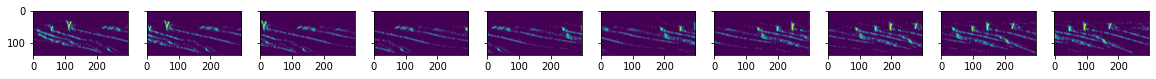

In [ ]:
fig, axes = plt.subplots(ncols=10, figsize=(20,3), sharex=True, sharey=True)
[fig.axes[idx].imshow(slicedata_train[idx]) for idx in range(len(fig.axes))]
plt.show()

## Define and train a simple model

In [ ]:
ydim = slicedata_train[-1].shape[0]
tdim = slicedata_train[-1].shape[1]

Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 


In [ ]:
n_samples = 10
batchsize = 3
y_sample_coords = torch.randint(0,ydim,(n_samples,))
t_sample_coords = torch.randint(0,tdim,(n_samples,))
yt_coords = torch.stack((y_sample_coords, t_sample_coords), dim=-1)
print(yt_coords.shape)

torch.Size([10, 2])


In [ ]:
slicedata_train[0].shape

torch.Size([139, 297])

In [ ]:
yt_coords.shape

torch.Size([10, 2])

In [ ]:
test_batch = torch.stack((slicedata_train[0], slicedata_train[1], slicedata_train[2]))
test_batch[:, yt_coords[:,0], yt_coords[:,1]].shape

torch.Size([3, 10])

TODO:
1. Switch to training on a single image (for initial regression testing)

In [ ]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from catalyst import dl
from catalyst.contrib.data.transforms import ToTensor
from catalyst.contrib.datasets import MNIST
from catalyst.utils import metrics
from catalyst.contrib.nn import OneCycleLRWithWarmup
import numpy as np
import math

num_epochs=1000
loaders = {
    "train": DataLoader(oneslice_train, batch_size=1), #DataLoader(slicedata_train, batch_size=40),
 #   "valid": DataLoader(slicedata_valid, batch_size=40),
}

# Kernels
rand_key = 42 # Seed
embedding_size =  256
b_scale =  torch.tensor(14)
n_coord_samples = slicedata_train[0].shape[0] * slicedata_train[0].shape[1]  #100  # 1000 random samples of the image coordinates
input_dim = slicedata_train[0].shape[0] * slicedata_train[0].shape[1] * n_coord_samples

# Dimension of the input coordinates defined here as 2 (t,y)
bvals = torch.normal(mean=torch.zeros(embedding_size, 2),
                     std=torch.ones(embedding_size, 2))
avals = torch.from_numpy(np.ones((bvals.shape[0]), dtype='float32'))

input_feature_size = bvals.shape[0]*bvals.shape[1] # =512
out_size = 1 # single intensity value output per pixel coordinate


input_encoder = lambda x, a, b: torch.cat([a * torch.sin((2.*math.pi*x) @ b.T), 
                                           a * torch.cos((2.*math.pi*x) @ b.T)], dim=-1)

class FourierMLP(nn.Module):

    def __init__(self, in_features, hid_features, out_features, a, b, b_scale):
        super().__init__()
        self.register_buffer("a", a)
        self.register_buffer("b", b)
        self.register_buffer('b_scale',b_scale)
        # TODO: Test and use the actual Fourier input encoder
        self.encoder = input_encoder
        self.mlp =     nn.Sequential(nn.Linear(in_features,  hid_features), nn.ReLU(),
                                     nn.Linear(hid_features, hid_features), nn.ReLU(),
                                     nn.Linear(hid_features, out_features))
        
    def forward(self, ty_coordinates):
        # ty_coordinates: (b, 100, 2) 
        z = self.encoder(ty_coordinates, self.a, self.b*self.b_scale)  # (b, 100, 512)
        x_hat = self.mlp(z)     # (b, 100, 1)
        return x_hat.squeeze()  # (b, 100)

model = FourierMLP(input_feature_size, embedding_size, out_size, avals, bvals, b_scale)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=num_epochs, 
    lr_range=(0.1, 0.001),
    warmup_steps=1
)

class CustomRunner(dl.Runner):

    def _handle_batch(self, batch):
        
        # One set of sampled y,t coordinates for all images in this batch
        y_sample_coords = torch.randint(0,ydim,(n_coord_samples,))
        t_sample_coords = torch.randint(0,tdim,(n_coord_samples,))
        yt_coords = torch.stack((y_sample_coords, t_sample_coords), dim=-1).cuda() # (100,2)
        
        repeated_yt_coords = torch.cat(batch.shape[0]*[yt_coords[None,...]]) # (b, 100, 2)
        x_hat = self.model(repeated_yt_coords)                  # (b, 100)

        x_at_coords = batch[...,yt_coords[:,0],yt_coords[:,1]]  # (b, 100)
        
        loss = F.mse_loss(x_hat, x_at_coords)

        self.batch_metrics = {
            "loss": loss,
        }

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

runner = CustomRunner()

In [ ]:
runner.train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    loaders=loaders,
    verbose=False,
)

[2020-06-25 01:18:03,939] 
1/1000 * Epoch 1 (train): loss=0.6094


/home/erik/.local/lib/python3.6/site-packages/catalyst/dl/experiment/experiment.py:164: UserWarning:

Attention, there is only one dataloader - train

/home/erik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning:

Using a target size (torch.Size([1, 41283])) that is different to the input size (torch.Size([41283])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



[2020-06-25 01:18:04,017] 
2/1000 * Epoch 2 (train): loss=45.5086
[2020-06-25 01:18:04,099] 
3/1000 * Epoch 3 (train): loss=0.2273
[2020-06-25 01:18:04,177] 
4/1000 * Epoch 4 (train): loss=0.6110
[2020-06-25 01:18:04,260] 
5/1000 * Epoch 5 (train): loss=0.6788
[2020-06-25 01:18:04,346] 
6/1000 * Epoch 6 (train): loss=0.6865
[2020-06-25 01:18:04,431] 
7/1000 * Epoch 7 (train): loss=0.6919
[2020-06-25 01:18:04,502] 
8/1000 * Epoch 8 (train): loss=0.6954
[2020-06-25 01:18:04,571] 
9/1000 * Epoch 9 (train): loss=0.6960
[2020-06-25 01:18:04,643] 
10/1000 * Epoch 10 (train): loss=0.6935
[2020-06-25 01:18:04,724] 
11/1000 * Epoch 11 (train): loss=0.6909
[2020-06-25 01:18:04,805] 
12/1000 * Epoch 12 (train): loss=0.6857
[2020-06-25 01:18:04,890] 
13/1000 * Epoch 13 (train): loss=0.6819
[2020-06-25 01:18:04,980] 
14/1000 * Epoch 14 (train): loss=0.6742
[2020-06-25 01:18:05,060] 
15/1000 * Epoch 15 (train): loss=0.6671
[2020-06-25 01:18:05,138] 
16/1000 * Epoch 16 (train): loss=0.6589
[2020-06-2

KeyboardInterrupt: 

In [ ]:
torch.nonzero(oneslice_train[0])[None,...]

tensor([[[  0,   0],
         [  0,   1],
         [  0,   2],
         ...,
         [138, 294],
         [138, 295],
         [138, 296]]])

TypeError: Invalid shape (41283,) for image data

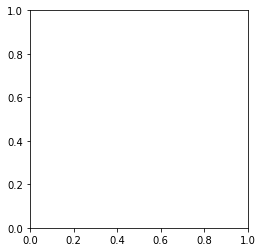

In [ ]:
reconstructed_tensor = model.cpu().forward(torch.nonzero(oneslice_train[0])[None]).T.data 
plt.imshow(reconstructed_tensor)

In [ ]:
plt.imshow(slicedata_train[400])